<a target="_blank" href="https://colab.research.google.com/github/RUTIK675LT/DM_assignment_5/blob/main/Image%20Data/images_dataset.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a target="_blank" href="https://medium.com/@rutikrasik.darda/data-mining-an-image-dataset-with-chat-gpt-4-ae5860b22326"><img src="https://github-readme-medium-recent-article.vercel.app/medium/@username/index" alt="Medium Article">

EDA -

In [13]:
!unzip /content/text_images.zip -d /content/dataset


Archive:  /content/text_images.zip
replace /content/dataset/image_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
img_path = '/content/dataset'

In [20]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [21]:
def extract_text_tesseract(img_path):
    # Read the image using PIL
    img = Image.open(img_path)
    # Use Tesseract to extract text
    text = pytesseract.image_to_string(img)
    return text.strip()


In [24]:
import os
from PIL import Image
import pytesseract


In [25]:
file_paths = [os.path.join("/content/dataset", file_name) for file_name in os.listdir("/content/dataset")]
labels = [extract_text_tesseract(img_path) for img_path in file_paths]


<Axes: >

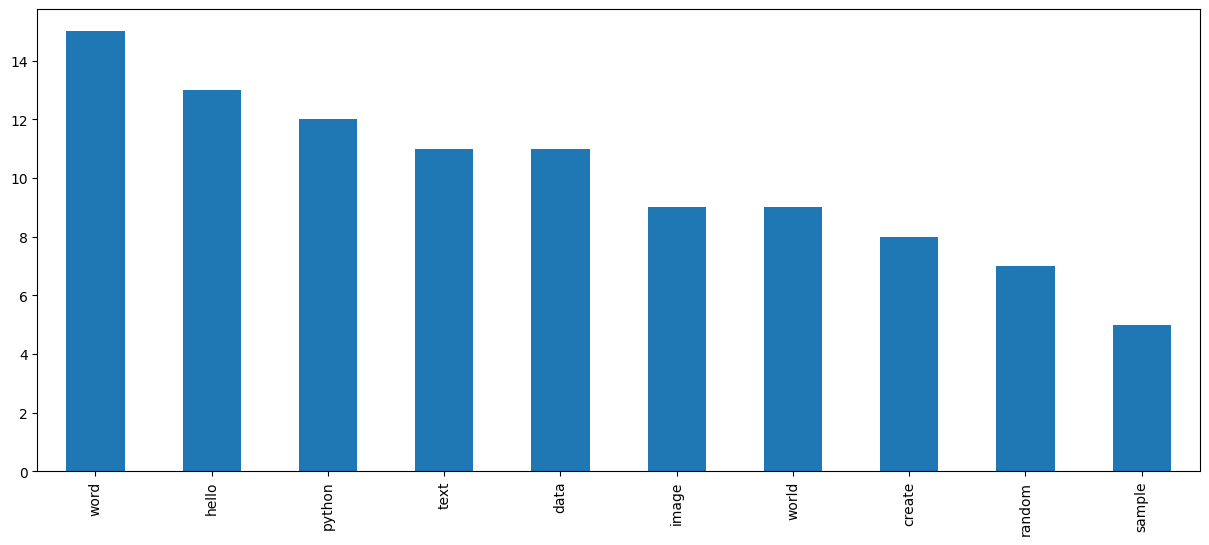

In [26]:
import pandas as pd
label_series = pd.Series(labels)
label_distribution = label_series.value_counts()
label_distribution.plot(kind='bar', figsize=(15, 6))


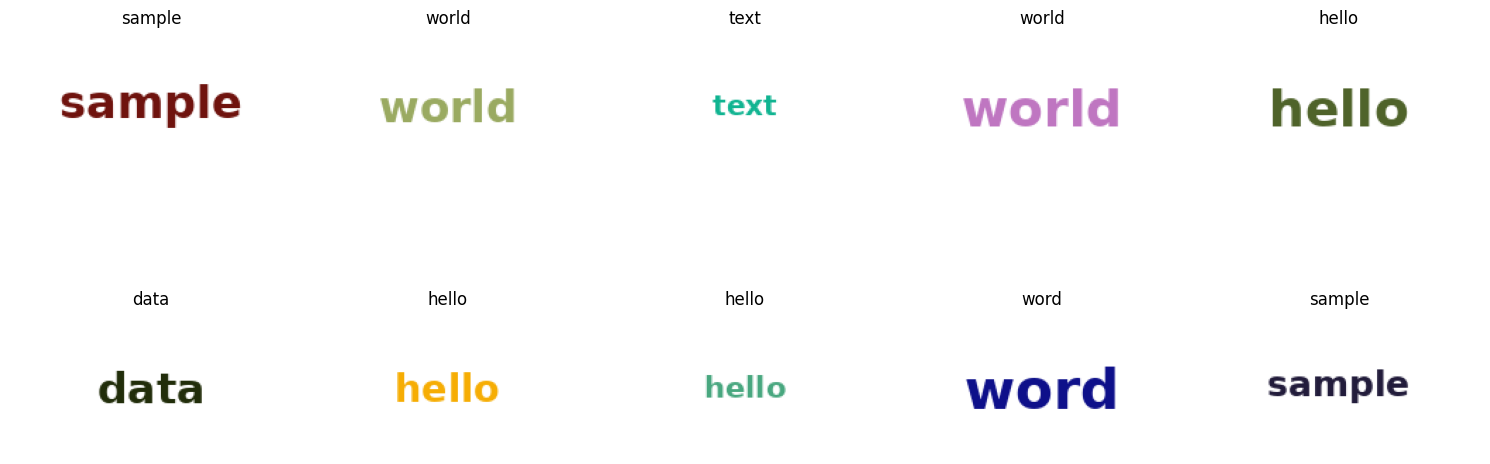

In [27]:
import random
import matplotlib.pyplot as plt

sample_indexes = random.sample(range(len(file_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axes.ravel()):
    img = Image.open(file_paths[sample_indexes[i]])
    ax.imshow(img)
    ax.set_title(labels[sample_indexes[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [28]:
image_shapes = [Image.open(img_path).size for img_path in file_paths]
widths, heights = zip(*image_shapes)

print(f"Average Width: {np.mean(widths)}")
print(f"Average Height: {np.mean(heights)}")
print(f"Standard Deviation of Width: {np.std(widths)}")
print(f"Standard Deviation of Height: {np.std(heights)}")


Average Width: 200.0
Average Height: 100.0
Standard Deviation of Width: 0.0
Standard Deviation of Height: 0.0


In [29]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, encoded_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


**Clustering -**

In [31]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing import image
import numpy as np

# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    return features.squeeze()

features = [extract_features(img_path, model) for img_path in file_paths]


1/1 [==============================] - 1s 528ms/step


In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust number of components as needed
reduced_features = pca.fit_transform(features)


In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(reduced_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


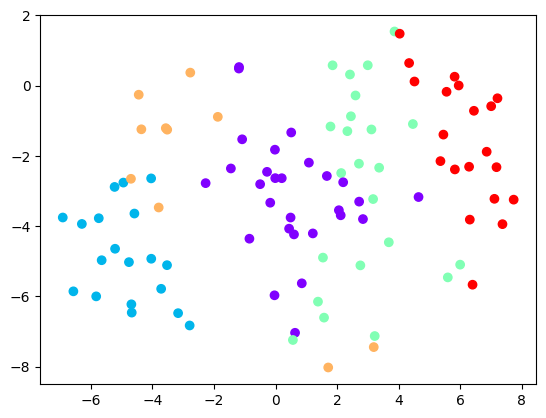

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(reduced_features)

plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=clusters, cmap='rainbow')
plt.show()


**Model -**

In [35]:
import pandas as pd
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    return features.squeeze()

features_list = [extract_features(img_path, model) for img_path in file_paths]

# Convert features to DataFrame
df_features = pd.DataFrame(features_list)

# Assuming you have extracted labels using Tesseract
df_features['label'] = labels


1/1 [==============================] - 1s 517ms/step


In [38]:
!pip install pycaret
!pip install --upgrade scipy

from pycaret.classification import *

# Setup PyCaret
setup(data=df_features, target='label')

# Compare models to choose the best one
best_model = compare_models()

# Create a model (for example, a Random Forest classifier)
rf_model = create_model('rf')





  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

,Description,Value
0,Session id,7428
1,Target,label
2,Target type,Multiclass
3,Target mapping,"create: 0, data: 1, hello: 2, image: 3, python: 4, random: 5, sample: 6, text: 7, word: 8, world: 9"
4,Original data shape,"(100, 4097)"
5,Transformed data shape,"(100, 4097)"
6,Transformed train set shape,"(70, 4097)"
7,Transformed test set shape,"(30, 4097)"
8,Numeric features,4096
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7714,0.0000,0.7714,0.7048,0.7262,0.7355,0.7631,0.2530
lr,Logistic Regression,0.6571,0.0000,0.6571,0.5762,0.6038,0.6045,0.6339,3.3230
lightgbm,Light Gradient Boosting Machine,0.6286,0.0000,0.6286,0.5464,0.5724,0.5754,0.6120,8.4170
rf,Random Forest Classifier,0.5857,0.0000,0.5857,0.5000,0.5276,0.5254,0.5538,0.4290
xgboost,Extreme Gradient Boosting,0.5714,0.0000,0.5714,0.4881,0.5133,0.5065,0.5369,4.8310
lda,Linear Discriminant Analysis,0.5571,0.0000,0.5571,0.4786,0.5048,0.4935,0.5235,0.3790
et,Extra Trees Classifier,0.5571,0.0000,0.5571,0.4667,0.4943,0.4899,0.5228,0.4440
gbc,Gradient Boosting Classifier,0.5429,0.0000,0.5429,0.4524,0.4810,0.4822,0.5210,20.4360
nb,Naive Bayes,0.4714,0.0000,0.4714,0.3714,0.4010,0.3859,0.4230,0.2280
svm,SVM - Linear Kernel,0.4714,0.0000,0.4714,0.3270,0.3688,0.3921,0.4265,0.4450


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5714,0.0000,0.5714,0.4762,0.5143,0.4878,0.5270
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.7143,0.0000,0.7143,0.6429,0.6667,0.6744,0.7075
3,0.4286,0.0000,0.4286,0.3571,0.3810,0.3488,0.3660
4,0.8571,0.0000,0.8571,0.7857,0.8095,0.8333,0.8539
5,0.4286,0.0000,0.4286,0.2857,0.3333,0.3636,0.4005
6,0.5714,0.0000,0.5714,0.4048,0.4524,0.5000,0.5557
7,0.4286,0.0000,0.4286,0.3571,0.3810,0.3636,0.4005
8,0.4286,0.0000,0.4286,0.3333,0.3571,0.3488,0.3858


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

NameError: ignored

In [39]:
# Save the model
save_model(rf_model, 'tuned_random_forest_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29',...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf